
## Pavement Crack Inspection with CNNs and Vision Transformers
Pavement crack inspection is crucial for maintaining safe and efficient road infrastructure. Deep learning, particularly Convolutional Neural Networks (CNNs) and Vision Transformers (ViTs), have emerged as powerful tools for automating this process.

## CNN:

Traditionally used for crack detection and segmentation.
Leverage convolutional layers to extract local features like edges and textures.
Established models like DeepLabV3+ and U-Net show good performance.
Limitations: May struggle with long-range dependencies and global context.

## Vision Transformers (ViTs):

Recent architecture gaining traction for pavement crack inspection.
Utilize self-attention mechanisms to capture long-range dependencies and global context.
Models like Segformer and UperNet-Swin transformer show promising results.
Advantages: Potentially better at handling complex and varied crack patterns.



## Convolutional Neural Network

In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of artificial neural network (ANN), most commonly applied to analyze visual imagery. CNNs are also known as Shift Invariant or Space Invariant Artificial Neural Networks (SIANN), based on the shared-weight architecture of the convolution kernels or filters that slide along input features and provide translation-equivariant responses known as feature maps. Counter-intuitively, most convolutional neural networks are not invariant to translation, due to the downsampling operation they apply to the input. They have applications in image and video recognition, recommender systems, image classification, image segmentation, medical image analysis, natural language processing, brain–computer interfaces, and financial time series.

<img src= https://cdn.discuss.boardinfinity.com/original/2X/1/1f1bf9539699c880b33f978e724f803ef8197f6f.png width=700/>

CNNs are regularized versions of multilayer perceptrons. Multilayer perceptrons usually mean fully connected networks, that is, each neuron in one layer is connected to all neurons in the next layer. The "full connectivity" of these networks make them prone to overfitting data. Typical ways of regularization, or preventing overfitting, include: penalizing parameters during training (such as weight decay) or trimming connectivity (skipped connections, dropout, etc.) CNNs take a different approach towards regularization: they take advantage of the hierarchical pattern in data and assemble patterns of increasing complexity using smaller and simpler patterns embossed in their filters. Therefore, on a scale of connectivity and complexity, CNNs are on the lower extreme. 

## Vision Transformers(ViT)

The concept of Vision Transformer (ViT) is an extension of the original concept of Transformer. It is only the application of Transformer in the image domain with slight modification in the implementation in order to handle the different data modality. More specifically, a ViT uses different methods for tokenization and embedding. However, the generic architecture remains the same. An input image is split into a set of image patches, called visual tokens. The visual tokens are embedded into a set of encoded vectors of fixed dimension. The position of a patch in the image is embedded along with the encoded vector and fed into the transformer encoder network which is essentially the same as the one responsible for processing the text input. 

<img src=https://miro.medium.com/max/700/1*_c8SqxPMY_dsApyvDJ8HtA.gif width=600/>

There are multiple blocks in the ViT encoder and each block consists of three major processing elements: Layer Norm, Multi-head Attention Network (MSP) and Multi-Layer Perceptrons (MLP). Layer Norm keeps the training process on track and let model adapt to the variations among the training images. MSP is a network responsible for generation of attention maps from the given embedded visual tokens. These attention maps help network focus on most important regions in the image such as object(s). 

In [21]:
pip install -U tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


In [22]:
!nvidia-smi

Mon Feb  5 20:46:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Importing necessary libraries

In [23]:
!pip install visualkeras
import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline


## Setting up general parameters

In [24]:
# General parameters
epochs = 15
image_size = 240
np.random.seed(42)
tf.random.set_seed(42)

## Data Loading, Preperation and Visualization

In [25]:
os.listdir("/kaggle/input/concrete-and-pavement-crack-images",)


['Negative', 'Positive']

In [26]:
folder_path = ("/kaggle/input/concrete-and-pavement-crack-images")


In [27]:
import os
import cv2
import numpy as np

def load_and_process_dataset(folder_path):
    """Loads and processes images using alternative while loop structures."""

    dataset = []
    labels = []
    class_folders = ['Negative', 'Positive']

    class_index = 0
    while class_index < len(class_folders):
        class_folder = class_folders[class_index]
        images_path = os.path.join(folder_path, class_folder)

        image_index = 0
        while True:  # Loop infinitely until a "break" occurs
            try:
                image_name = os.listdir(images_path)[image_index]  # Access by index
                image_path = os.path.join(images_path, image_name)

                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
                image = cv2.resize(image, (240, 240))

                dataset.append(image)
                labels.append(class_index)  # Use class_index directly for labels

                image_index += 1
            except IndexError:  # Handle end of image list
                break  # Exit the inner loop

        class_index += 1

    return np.array(dataset), np.array(labels)

# Assuming `folder_path` is already a string
dataset, labels = load_and_process_dataset(folder_path)

# Convert to NumPy arrays
dataset = np.array(dataset)
lab = np.array(labels)

# Print shapes
print(dataset.shape, labels.shape)

(30000, 240, 240, 3) (30000,)


In [28]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(30000, 240, 240, 3) (30000,)


In [29]:
x_train, x_test, y_train, y_test = train_test_split(dataset, lab, test_size=0.2, shuffle=True, random_state=42)

In [30]:
import matplotlib.pyplot as plt

def plot_state(state):
    images = [load_img(os.path.join(folder_path, state, img_name), target_size=(image_size, image_size))
              for img_name in os.listdir(os.path.join(folder_path, state))[:9]]

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for ax, img in zip(axes.flat, images):
        ax.imshow(img)
    plt.show()

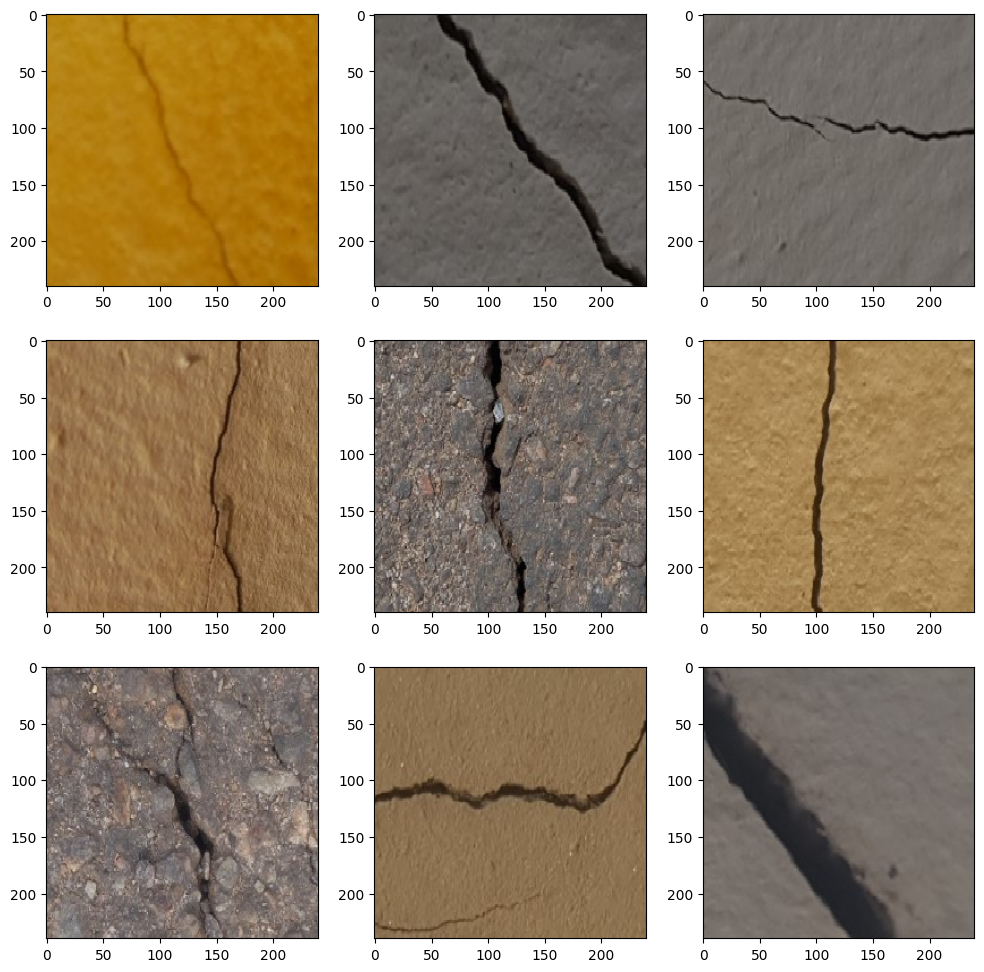

In [31]:
plot_state('Positive')

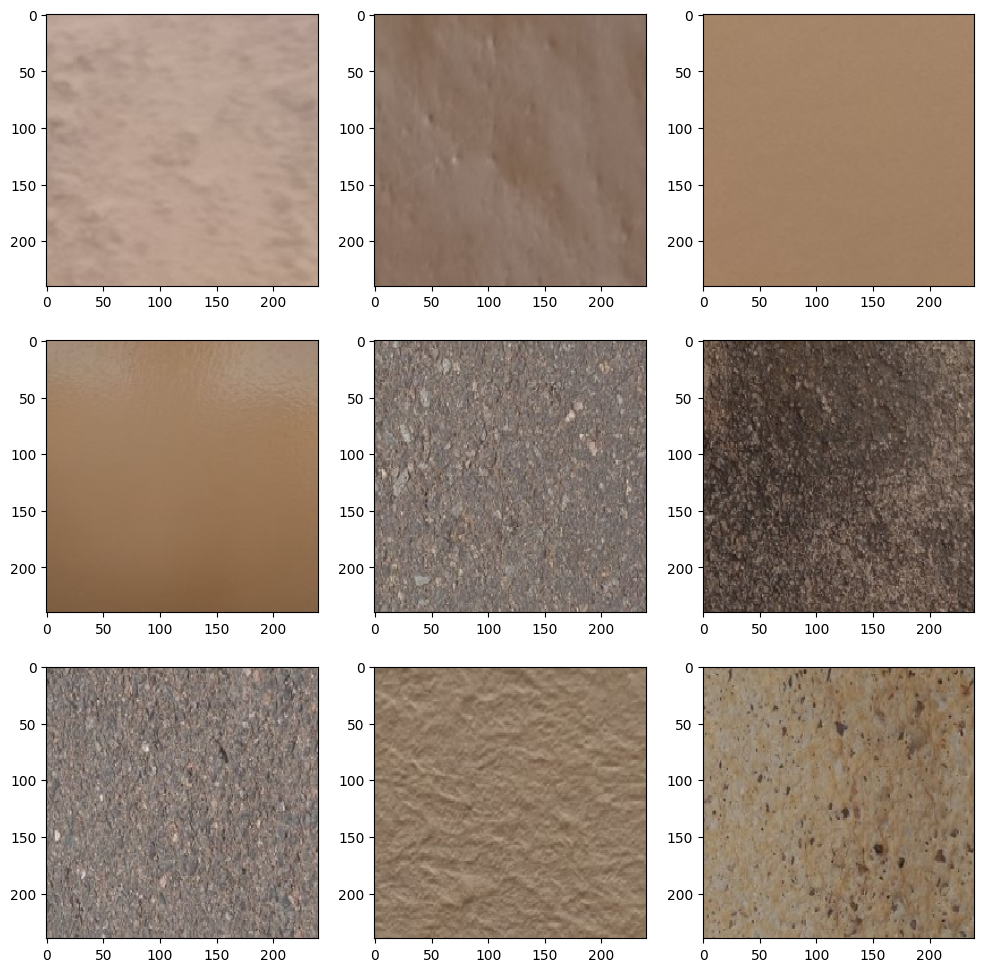

In [32]:
plot_state("Negative")

## Modeling using CNN

In [33]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(pic_size,pic_size,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 119, 119, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 64)                4

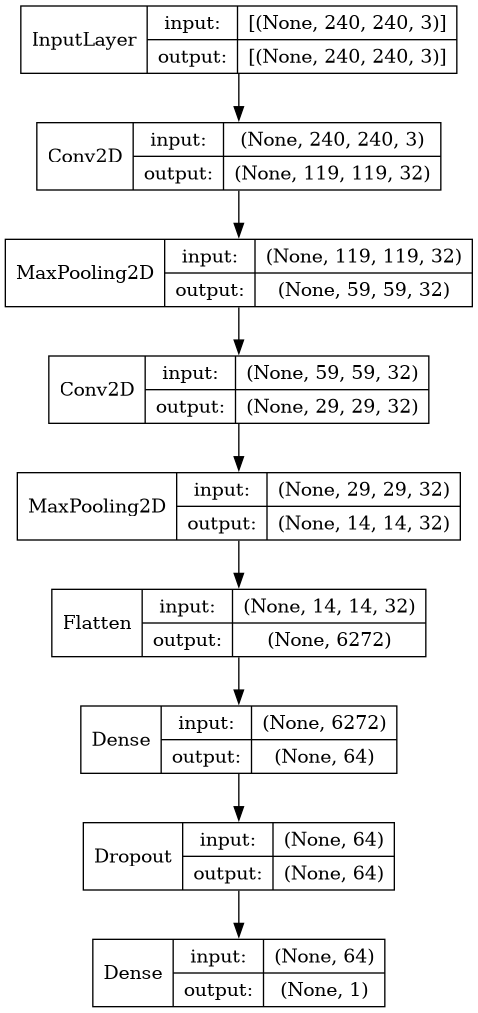

In [35]:
plot_model(model, show_shapes=True, show_layer_names=False)

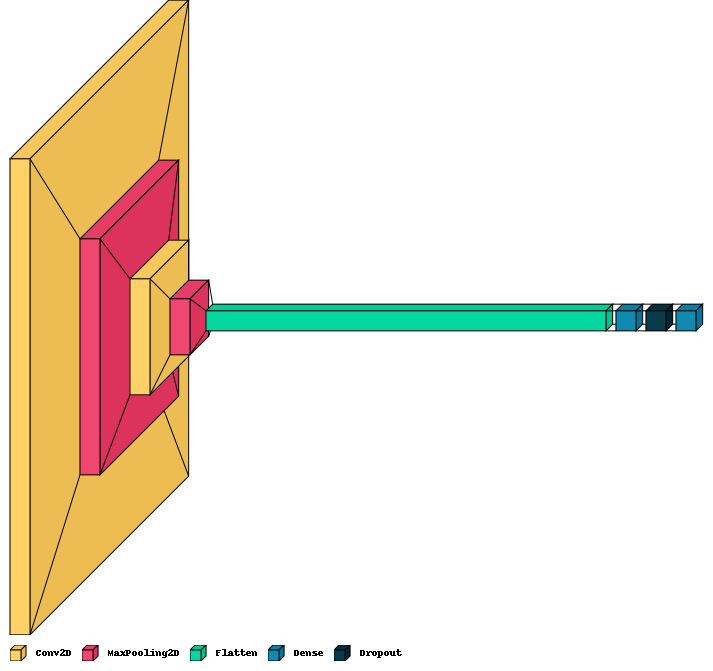

In [36]:
visualkeras.layered_view(model, legend=True)

In [37]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 1.0040160642570282, 1: 0.9960159362549801}

In [38]:
history = model.fit(x_train,y_train,epochs = 100, class_weight=class_weights, validation_data=(x_test, y_test),verbose=1)

Epoch 1/100


I0000 00:00:1707166259.101927     171 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 [==============================] - 16s 14ms/step - loss: 2.4391 - accuracy: 0.5494 - val_loss: 2.3193 - val_accuracy: 0.7117
Epoch 2/100
750/750 [==============================] - 8s 11ms/step - loss: 1.1378 - accuracy: 0.8178 - val_loss: 0.8695 - val_accuracy: 0.8778
Epoch 3/100
750/750 [==============================] - 8s 11ms/step - loss: 0.7357 - accuracy: 0.8749 - val_loss: 0.5867 - val_accuracy: 0.8892
Epoch 4/100
750/750 [==============================] - 8s 11ms/step - loss: 0.5374 - accuracy: 0.8899 - val_loss: 0.4549 - val_accuracy: 0.9005
Epoch 5/100
750/750 [==============================] - 8s 11ms/step - loss: 0.4648 - accuracy: 0.8961 - val_loss: 0.4306 - val_accuracy: 0.8962
Epoch 6/100
750/750 [==============================] - 8s 11ms/step - loss: 0.4337 - accuracy: 0.8990 - val_loss: 0.4170 - val_accuracy: 0.9102
Epoch 7/100
750/750 [==============================] - 8s 11ms/step - loss: 0.4420 - accuracy: 0.8999 - val_loss: 0.4292 - val_accuracy: 0.9107
Epo

## CNN model Evaluation

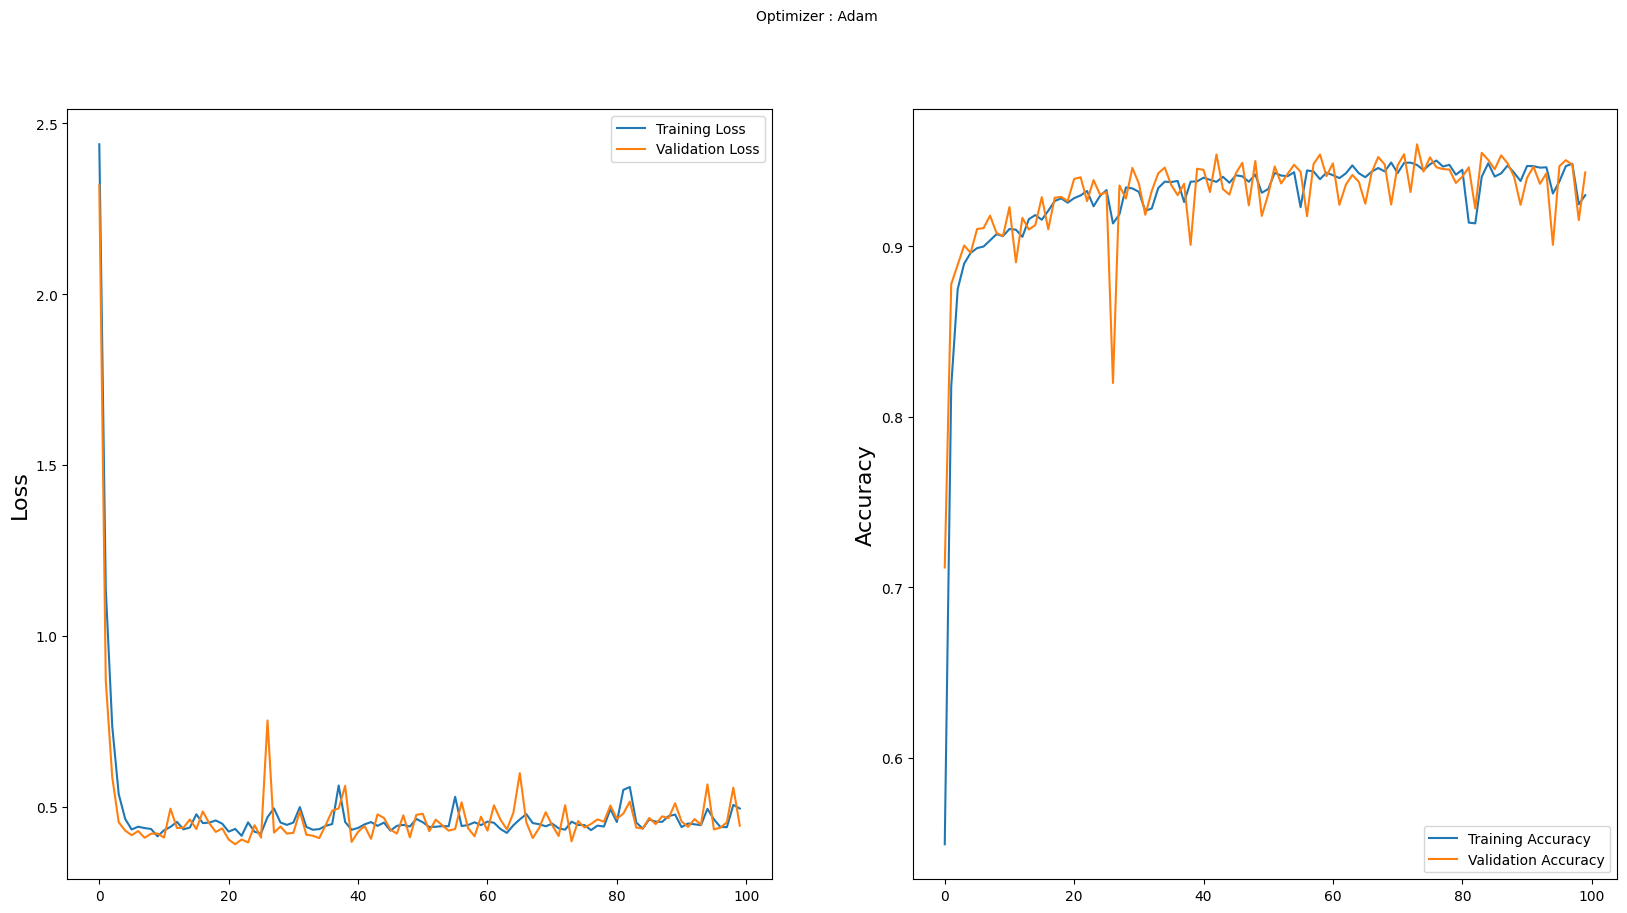

In [39]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [40]:
results = model.evaluate(x_test, y_test)
print('The current model achieved an accuracy of {}%!'.format(round(results[1]*100,2)))

188/188 [==============================] - 1s 6ms/step - loss: 0.4449 - accuracy: 0.9433
The current model achieved an accuracy of 94.33%!


In [41]:
# compute predictions
predictions = model.predict(x_test)
y_pred = []
for i in predictions:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

188/188 [==============================] - 1s 4ms/step


In [42]:
predictions = model.predict(x_test)
y_pred = (predictions >= 0.5).astype(int)

188/188 [==============================] - 1s 4ms/step


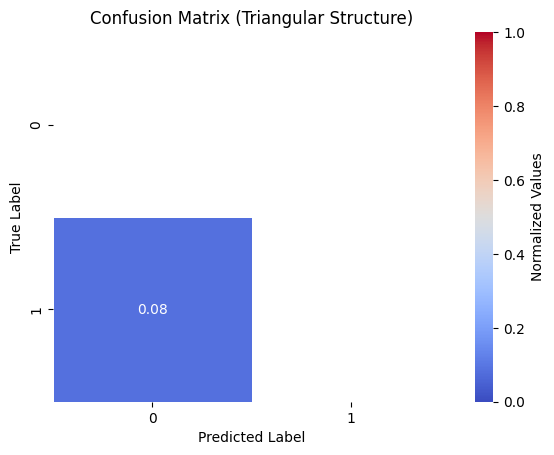

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Normalize for better visualization
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

# Employ a triangular structure for visual clarity
mask = np.triu(np.ones_like(cnf_matrix_norm, dtype=bool))

# Create a visually distinct heatmap with a different colormap
sns.heatmap(cnf_matrix_norm, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', vmin=0, vmax=1,
            linewidths=0.5, cbar_kws={'label': 'Normalized Values'})

# Customize labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Triangular Structure)')

plt.show()

    

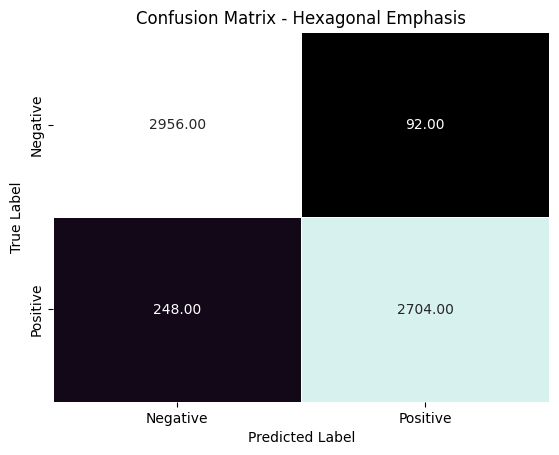

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Create a hexagonal mask for a visually striking shape
mask = np.triu(np.ones_like(cnf_matrix, dtype=bool)) & np.tril(np.ones_like(cnf_matrix, dtype=bool), k=-1)

# Plot using Seaborn with distinct customizations
sns.heatmap(
    cnf_matrix,
    annot=True,
    fmt='.2f',
    cmap='cubehelix',  # Employ a vibrant colormap
    mask=mask,
    linewidths=0.5,
    cbar=False,
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)
plt.title('Confusion Matrix - Hexagonal Emphasis')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Modeling using Vision Transformers(ViT)

In [45]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 240  # We'll resize input images to this size
patch_size = 20  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Data augmentation

In [46]:
data_augmentation = tf.keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Multi-layer perceptron

In [47]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [48]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 240 X 240
Patch size: 20 X 20
Patches per image: 144
Elements per patch: 1200


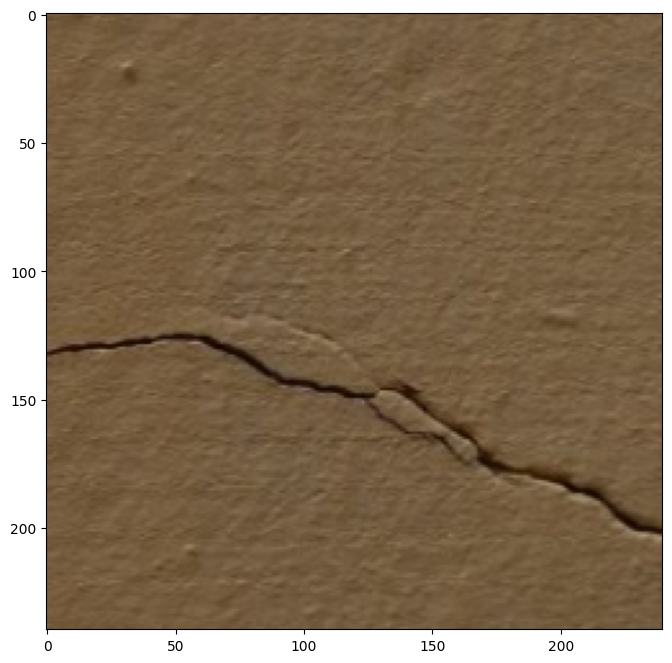

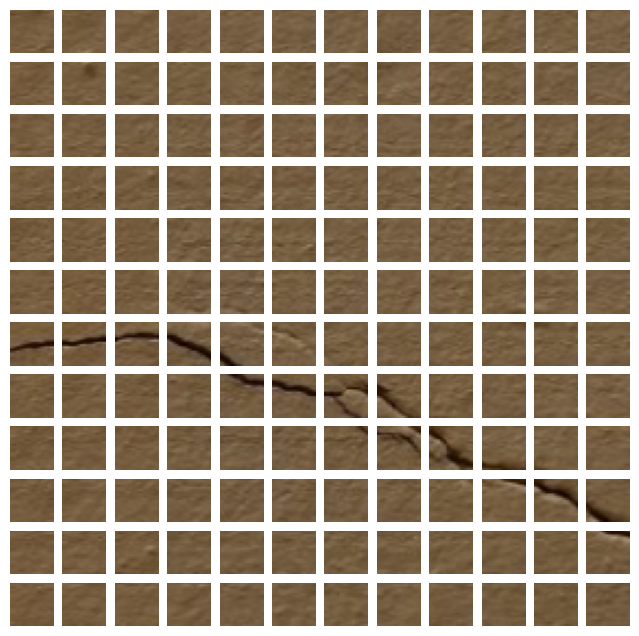

In [49]:
plt.figure(figsize=(8, 8))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


## Creating the patch encoder
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [50]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Building the ViT

The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the paper, which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with layers.Flatten() and used as the image representation input to the classifier head. Note that the layers.GlobalAveragePooling1D layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.

## ViTs and Data Dependency:

Large Model Capacity: ViTs have a much larger number of parameters compared to CNNs. This makes them excellent at capturing complex relationships within large datasets, allowing them to learn nuanced features. However, on small datasets, these numerous parameters can overfit the limited data, leading to poor generalization and potentially worse performance compared to simpler models like CNNs.

## Data Augmentation Importance:

ViTs heavily rely on data augmentation techniques like random cropping, rotation, and color jittering to artificially expand the dataset and prevent overfitting. With small datasets, these techniques become less effective, further hindering ViT performance.

In [51]:
def create_vit_classifier():
    inputs = layers.Input(shape=(240, 240, 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(2)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model


In [52]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=10,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [53]:
vit_classifier = create_vit_classifier()
vit_history = run_experiment(vit_classifier)

Epoch 1/15
94/94 [==============================] - 59s 479ms/step - loss: 1.3710 - accuracy: 0.6539 - top-5-accuracy: 1.0000 - val_loss: 0.4672 - val_accuracy: 0.7533 - val_top-5-accuracy: 1.0000
Epoch 2/15
94/94 [==============================] - 42s 445ms/step - loss: 0.3573 - accuracy: 0.8327 - top-5-accuracy: 1.0000 - val_loss: 0.2276 - val_accuracy: 0.8998 - val_top-5-accuracy: 1.0000
Epoch 3/15
94/94 [==============================] - 42s 448ms/step - loss: 0.1921 - accuracy: 0.9197 - top-5-accuracy: 1.0000 - val_loss: 0.1417 - val_accuracy: 0.9422 - val_top-5-accuracy: 1.0000
Epoch 4/15
94/94 [==============================] - 42s 447ms/step - loss: 0.1494 - accuracy: 0.9417 - top-5-accuracy: 1.0000 - val_loss: 0.1203 - val_accuracy: 0.9488 - val_top-5-accuracy: 1.0000
Epoch 5/15
94/94 [==============================] - 42s 448ms/step - loss: 0.1101 - accuracy: 0.9593 - top-5-accuracy: 1.0000 - val_loss: 0.0738 - val_accuracy: 0.9727 - val_top-5-accuracy: 1.0000
Epoch 6/15
94/9

## Notes about the ViT performance

The state of the art results reported in the paper are achieved by pre-training the ViT model using the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality without pre-training, you can try to train the model for more epochs, use a larger number of Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, but also by parameters such as the learning rate schedule, optimizer, weight decay, etc. In practice, it's recommended to fine-tune a ViT model that was pre-trained using a large, high-resolution dataset.

## ViT model Evaluation

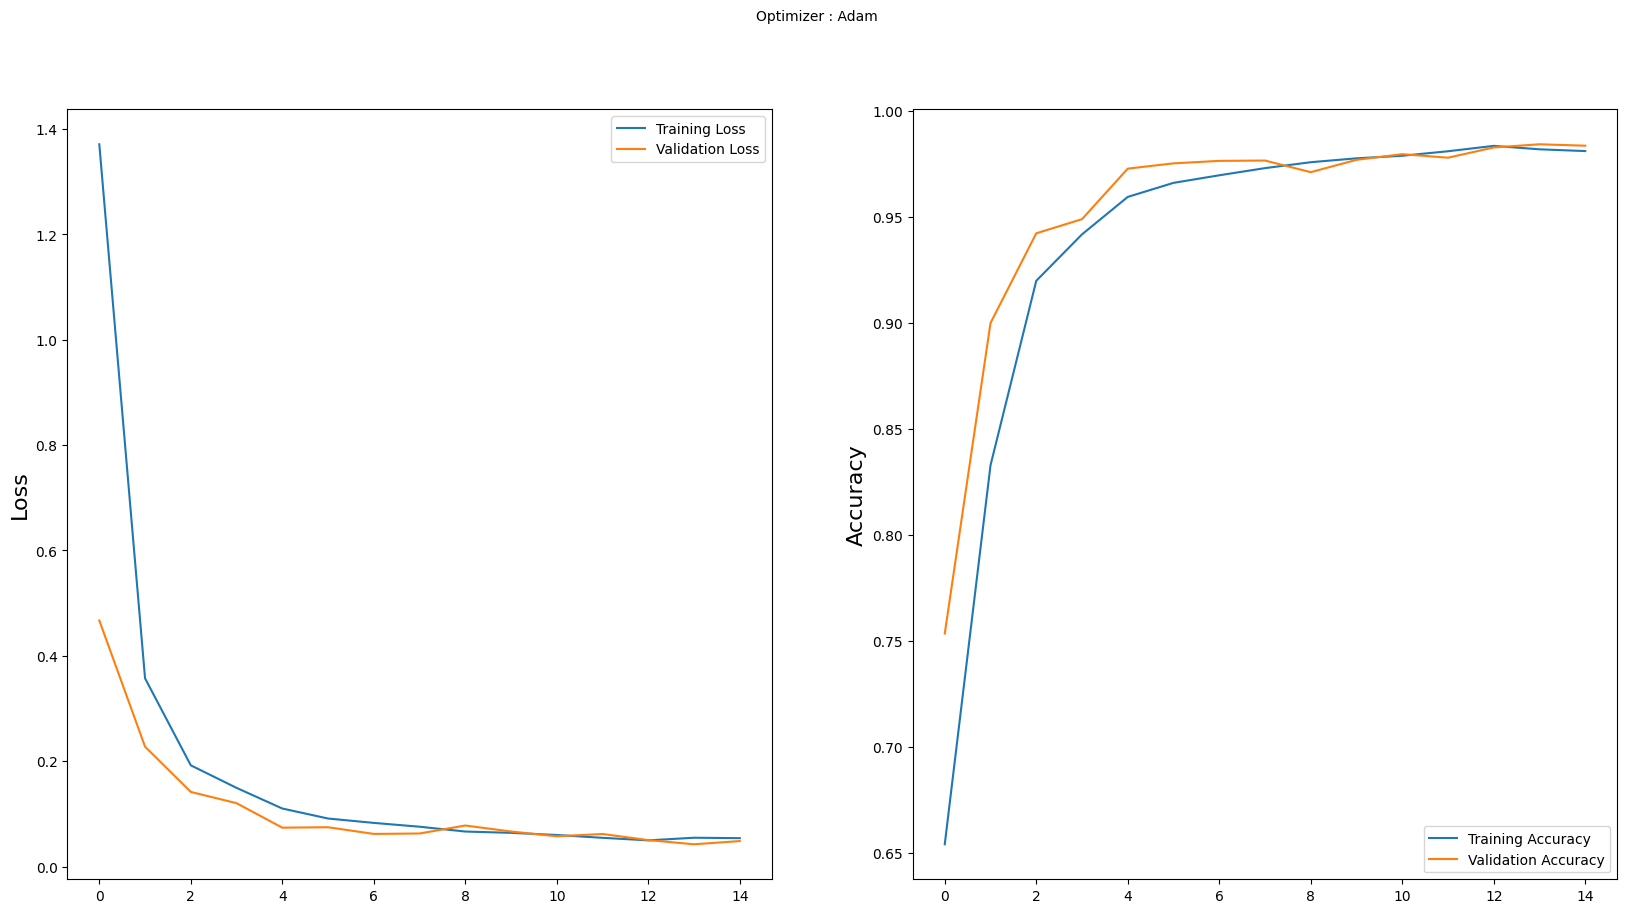

In [54]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(vit_history.history['loss'], label='Training Loss')
plt.plot(vit_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(vit_history.history['accuracy'], label='Training Accuracy')
plt.plot(vit_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [55]:
# compute predictions
vit_predictions = vit_classifier.predict(x_test)
vit_y_pred = [np.argmax(probas) for probas in vit_predictions]

188/188 [==============================] - 6s 26ms/step


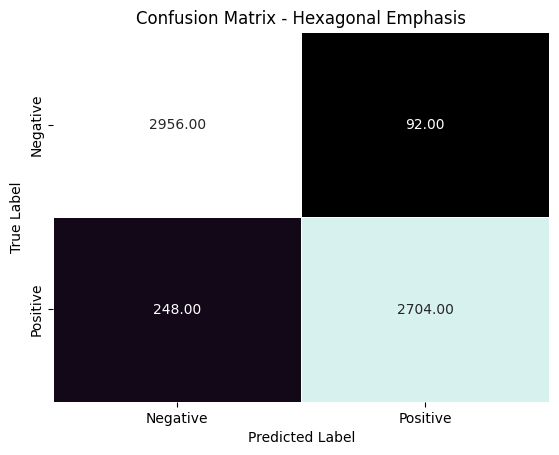

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Create a hexagonal mask for a visually striking shape
mask = np.triu(np.ones_like(cnf_matrix, dtype=bool)) & np.tril(np.ones_like(cnf_matrix, dtype=bool), k=-1)

# Plot using Seaborn with distinct customizations
sns.heatmap(
    cnf_matrix,
    annot=True,
    fmt='.2f',
    cmap='cubehelix',  # Employ a vibrant colormap
    mask=mask,
    linewidths=0.5,
    cbar=False,
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)
plt.title('Confusion Matrix - Hexagonal Emphasis')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()